<a href="https://colab.research.google.com/github/virf96/Basico/blob/main/Gaussian_Mixture_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Mixture Models

## Preparación de ambiente

In [ ]:
import pandas as pd
import cufflinks as cf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples

cf.go_offline()

### Funciones relevantes

In [ ]:
def pivot_categories(df, cluster_column, categories):
    aux = df.copy()
    aux["dum"] = 1
    for i, col in enumerate(categories):
        agg_data = aux[[cluster_column, col, "dum"]].pivot_table(index = cluster_column, columns=col, aggfunc="sum", fill_value=0)
        agg_data.columns = [f"{col}_{x}" for x in agg_data.columns.droplevel(0)]
        for col in agg_data:
            agg_data[col] /= agg_data.sum(axis=1)
        if i == 0:
            final = agg_data.copy()
        else:
            final = final.merge(agg_data, left_index = True, right_index = True, how = "inner")
    return final

## Data Wrangling

### Carga de datos

In [ ]:
portfolio = pd.read_json('./starbucks/portfolio.json', orient='records', lines=True)
profile = pd.read_json('./starbucks/profile.json', orient='records', lines=True)
trx = pd.read_json('./starbucks/transcript.json', orient='records', lines=True)

In [ ]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [ ]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [ ]:
trx

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


### EDA

In [ ]:
print(trx.shape)
trx.head()

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [ ]:
trx["event"].fillna("---").value_counts(True)

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

In [ ]:
print(portfolio.shape)
portfolio.head()

(10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


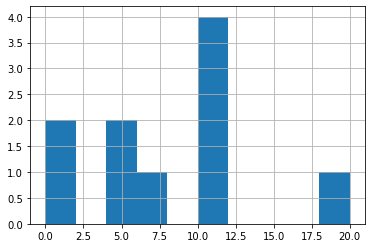

In [ ]:
portfolio["difficulty"].hist()

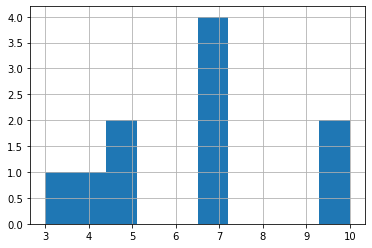

In [ ]:
portfolio["duration"].hist()

In [ ]:
portfolio["offer_type"].fillna("---").value_counts(True)

bogo             0.4
discount         0.4
informational    0.2
Name: offer_type, dtype: float64

In [ ]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [ ]:
profile["gender"].fillna("----").value_counts(True)

M       0.499059
F       0.360529
----    0.127941
O       0.012471
Name: gender, dtype: float64

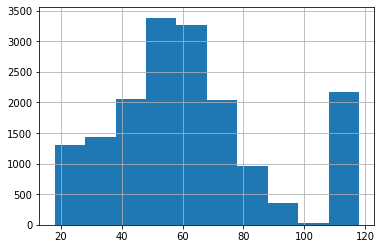

In [ ]:
profile["age"].hist()

In [ ]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [ ]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0


### Limpieza

In [ ]:
profile["gender"].fillna("Missing", inplace=True)

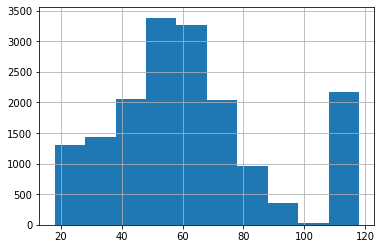

In [ ]:
profile["age"].hist()

In [ ]:
profile[profile["income"].isnull()]

,gender,age,id,became_member_on,income
0,Missing,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
2,Missing,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
4,Missing,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
6,Missing,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN
7,Missing,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN
...,...,...,...,...,...
16980,Missing,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN
16982,Missing,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN
16989,Missing,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN
16991,Missing,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN


In [ ]:
profile = profile[profile["age"]<=100].reset_index(drop = True)

In [ ]:
profile["age"].describe()

count    14820.000000
mean        54.377800
std         17.365541
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        100.000000
Name: age, dtype: float64

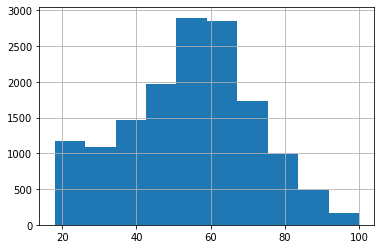

In [ ]:
profile["age"].hist()

In [ ]:
trx[trx["event"] == "transaction"].sample(5)

,person,event,value,time
37731,c03098114fd246dd99b694214ae9800a,transaction,{'amount': 8.45},78
51791,c0bdfd5f10d84c1e981c48c48373e983,transaction,{'amount': 6.68},156
46394,b75f93132fa040c8a2ef895cd7be10ce,transaction,{'amount': 3.76},120
223076,f72eee165c90470285c8f960ead8e33a,transaction,{'amount': 3.58},516
301107,f72eee165c90470285c8f960ead8e33a,transaction,{'amount': 1.79},690


In [ ]:
transactions = trx[trx["event"] == "transaction"]
transactions["amount"] = transactions["value"].map(lambda x:x["amount"])
transactions = transactions[["person", "amount", "time"]].groupby("person").agg({"amount": ["min", "max", "mean", "count", "sum"], "time": ["mean"]})
transactions.columns = ["_".join(x) for x in transactions.columns]
transactions.reset_index(drop = False, inplace=True)

In [ ]:
transactions

,person,amount_min,amount_max,amount_mean,amount_count,amount_sum,time_mean
0,0009655768c64bdeb2e877511632db8f,8.57,28.16,15.950000,8,127.60,543.00
1,00116118485d4dfda04fdbaba9a87b5c,0.20,3.19,1.363333,3,4.09,408.00
2,0011e0d4e6b944f998e987f904e8c1e5,8.96,23.03,15.892000,5,79.46,451.20
3,0020c2b971eb4e9188eac86d93036a77,17.24,33.86,24.607500,8,196.86,348.75
4,0020ccbbb6d84e358d3414a3ff76cffd,6.81,20.08,12.837500,12,154.05,375.00
...,...,...,...,...,...,...,...
16573,fff3ba4757bd42088c044ca26d73817a,10.99,388.22,52.816364,11,580.98,246.00
16574,fff7576017104bcc8677a8d63322b5e1,2.08,8.01,4.990000,6,29.94,392.00
16575,fff8957ea8b240a6b5e634b6ee8eafcf,0.64,6.39,2.430000,5,12.15,379.20
16576,fffad4f4828548d1b5583907f2e9906b,2.05,12.18,7.402500,12,88.83,323.50


In [ ]:
X = profile[["age", "income", "id"]].merge(transactions, left_on="id", right_on="person", how = "inner").drop(columns=["id"]).set_index("person")

In [ ]:
X

,age,income,amount_min,amount_max,amount_mean,amount_count,amount_sum,time_mean
person,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55,112000.0,21.51,32.28,25.670000,3,77.01,230.000000
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,17.78,29.72,22.752857,7,159.27,308.571429
e2127556f4f64592b11af22de27a7932,68,70000.0,17.88,21.43,19.243333,3,57.73,368.000000
389bc3fa690240e798340f5a15918d5c,65,53000.0,9.54,15.63,12.143333,3,36.43,386.000000
2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,0.87,7.14,3.905000,4,15.62,405.000000
...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,45,54000.0,1.18,3.92,2.861429,7,20.03,319.714286
2cb4f97358b841b9a9773a7aa05a9d77,61,72000.0,2.24,6.46,3.710000,7,25.97,355.714286
01d26f638c274aa0b965d24cefe3183f,49,73000.0,1.74,8.26,4.967500,8,39.74,435.000000


In [ ]:
vect = CountVectorizer(ngram_range=(1,1))

In [ ]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [ ]:
channels = pd.DataFrame(data=vect.fit_transform(portfolio["channels"].str.join(" ")).todense(), columns=vect.get_feature_names(), index=portfolio.index)
portfolio = portfolio.join(channels).drop(columns=["channels"])

In [ ]:
portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [ ]:
sc = MinMaxScaler()

In [ ]:
Xs = pd.DataFrame(data=sc.fit_transform(X), columns=X.columns, index=X.index)

In [ ]:
Xs

,age,income,amount_min,amount_max,amount_mean,amount_count,amount_sum,time_mean
person,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,0.451220,0.911111,0.428943,0.030251,0.056545,0.057143,0.047782,0.310541
78afa995795e4d85b5d9ceeca43f5fef,0.695122,0.777778,0.354387,0.027840,0.050082,0.171429,0.098922,0.422466
e2127556f4f64592b11af22de27a7932,0.609756,0.444444,0.356386,0.020035,0.042306,0.057143,0.035796,0.507123
389bc3fa690240e798340f5a15918d5c,0.573171,0.255556,0.189686,0.014574,0.026574,0.057143,0.022555,0.532764
2eeac8d8feae4a8cad5a6af0499a211d,0.487805,0.233333,0.016390,0.006581,0.008320,0.085714,0.009617,0.559829
...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,0.329268,0.266667,0.022586,0.003549,0.006008,0.171429,0.012359,0.438339
2cb4f97358b841b9a9773a7aa05a9d77,0.524390,0.466667,0.043774,0.005941,0.007888,0.171429,0.016052,0.489621
01d26f638c274aa0b965d24cefe3183f,0.378049,0.477778,0.033780,0.007636,0.010674,0.200000,0.024612,0.602564


In [ ]:
pca = PCA(n_components=3)

In [ ]:
Xp = pd.DataFrame(data=pca.fit_transform(Xs), columns=["p1", "p2", "p3"], index=Xs.index)

In [ ]:
pca.explained_variance_ratio_.cumsum()

array([0.48558528, 0.69101127, 0.82102765])

In [ ]:
Xp.sample(frac=0.05).iplot(kind="scatter3d", mode="markers", x="p1", y="p2", z="p3")

In [ ]:
sse,db,slc = {}, {}, {}
for k in range(2, 15):
    cluster = GaussianMixture(n_components=k, random_state=10).fit(Xs)
    clusters = cluster.predict(Xs)
    db[k] = davies_bouldin_score(Xs,clusters)
    slc[k] = silhouette_score(Xs,clusters)

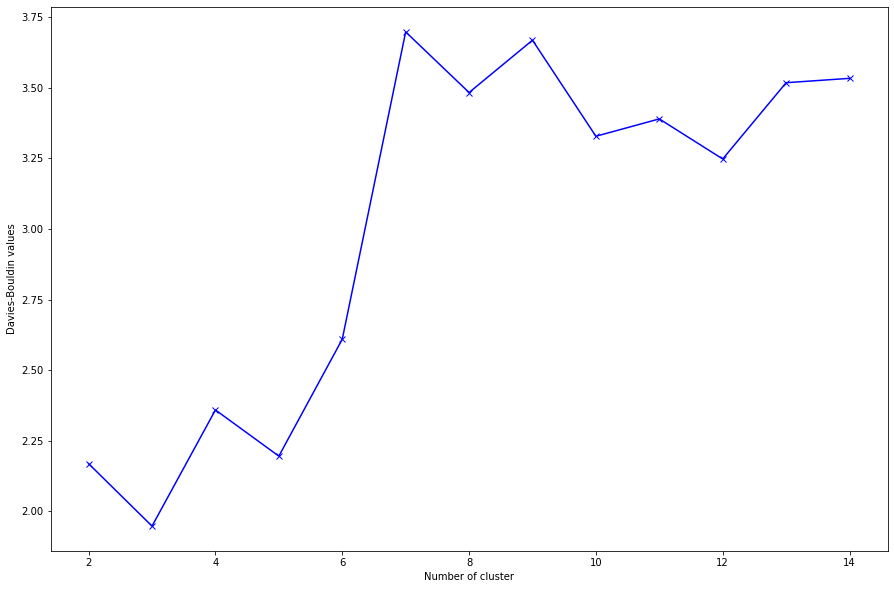

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(list(db.keys()), list(db.values()), "bx-")
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.show()

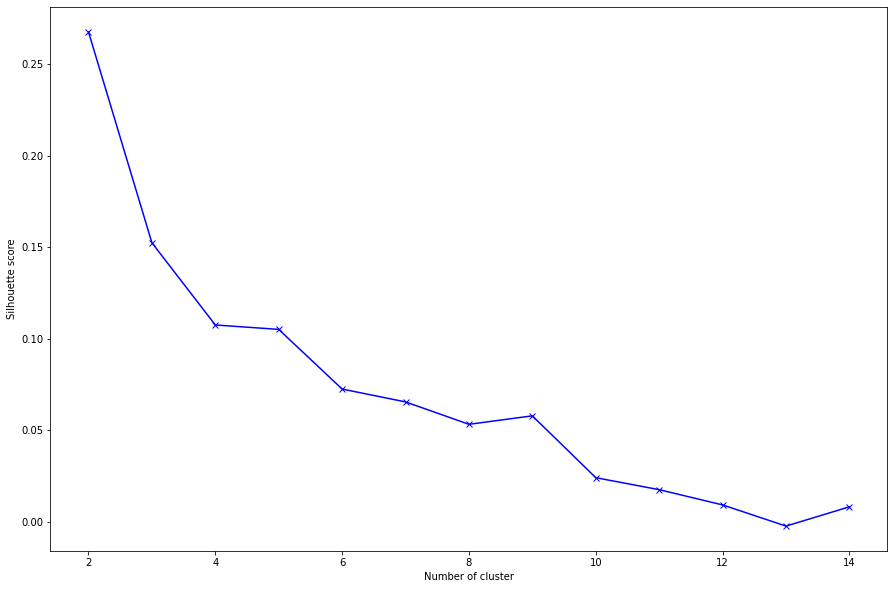

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(list(slc.keys()), list(slc.values()), "bx-")
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette score")
plt.show()

In [ ]:
GaussianMixture?

In [ ]:
cluster = GaussianMixture(n_components=3, random_state=10)

In [ ]:
cluster.fit(Xs)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=10, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
X["cl"] = Xs["cl"] = Xp["cl"] = [str(x) for x in cluster.predict(Xs)]

In [ ]:
Xp.sample(frac=0.1).iplot(kind="scatter3d", mode="markers", x="p1", y="p2", z="p3", categories="cl")

In [ ]:
X["cl"].value_counts(True)

0    0.637951
2    0.318078
1    0.043970
Name: cl, dtype: float64

In [ ]:
X.groupby("cl").mean().join(pivot_categories(df=X.join(profile.set_index("id")[["gender"]]), categories=["gender"], cluster_column="cl")).style.background_gradient(cmap='Blues')

,age,income,amount_min,amount_max,amount_mean,amount_count,amount_sum,time_mean,gender_F,gender_M,gender_O
cl,,,,,,,,,,,
0,57.700931,72814.001298,11.933807,27.228844,18.766147,7.994265,141.456478,388.135897,0.523804,0.964212,0.990611
1,51.896389,59649.921507,6.484600,334.350031,51.837501,12.532182,460.159812,377.316306,0.376766,0.981436,0.837501
2,47.779731,50750.434028,0.788099,7.205154,3.142818,9.124132,28.993468,394.278622,0.196832,0.989140,0.971204


In [ ]:
X[["cl"]]

,cl
person,
0610b486422d4921ae7d2bf64640c50b,0
78afa995795e4d85b5d9ceeca43f5fef,0
e2127556f4f64592b11af22de27a7932,0
389bc3fa690240e798340f5a15918d5c,0
2eeac8d8feae4a8cad5a6af0499a211d,2
...,...
6d5f3a774f3d4714ab0c092238f3a1d7,2
2cb4f97358b841b9a9773a7aa05a9d77,2
01d26f638c274aa0b965d24cefe3183f,2


In [ ]:
offers = trx[trx["event"] != "transaction"]

In [ ]:
offers

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},714
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714


In [ ]:
offers["offer"] = offers["value"].map(lambda x:x["offer_id"] if "offer_id" in x.keys() else x["offer id"])

In [ ]:
offers

,person,event,value,time,offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},714,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4


In [ ]:
portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [ ]:
offers = offers.merge(portfolio, left_on="offer", right_on="id")[["person", "event", "offer_type", "email", "mobile", "social", "web"]]

In [ ]:
offers

,person,event,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,bogo,1,1,0,1
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,bogo,1,1,0,1
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,bogo,1,1,0,1
3,c0d210398dee4a0895b24444a5fcd1d2,offer received,bogo,1,1,0,1
4,57dd18ec5ddc46828afb81ec5977bef2,offer received,bogo,1,1,0,1
...,...,...,...,...,...,...,...
167576,642b6f1bf61040efb73e1859cf00e79e,offer viewed,informational,1,1,1,0
167577,5a3f7fcb450a4cb693ab5267b4d49b40,offer viewed,informational,1,1,1,0
167578,ec1761735b034ae8874bc979f0cd5862,offer viewed,informational,1,1,1,0
167579,d56386cf344c4829bbf420d1895dca37,offer viewed,informational,1,1,1,0


In [ ]:
full = X[["cl"]].reset_index().merge(offers, on="person")

In [ ]:
full

,person,cl,event,offer_type,email,mobile,social,web
0,0610b486422d4921ae7d2bf64640c50b,0,offer received,bogo,1,1,0,1
1,0610b486422d4921ae7d2bf64640c50b,0,offer completed,bogo,1,1,0,1
2,0610b486422d4921ae7d2bf64640c50b,0,offer received,informational,1,1,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,0,offer received,bogo,1,1,0,1
4,78afa995795e4d85b5d9ceeca43f5fef,0,offer viewed,bogo,1,1,0,1
...,...,...,...,...,...,...,...,...
146132,e4052622e5ba45a8b96b59aba68cf068,0,offer received,discount,1,1,1,1
146133,e4052622e5ba45a8b96b59aba68cf068,0,offer viewed,discount,1,1,1,1
146134,e4052622e5ba45a8b96b59aba68cf068,0,offer completed,discount,1,1,1,1
146135,e4052622e5ba45a8b96b59aba68cf068,0,offer received,informational,1,1,0,1


In [ ]:
full["dum"] = 1

In [ ]:
for offer_type in full["offer_type"].unique():
    print(f"Clusters' reponse rates by {offer_type}")
    display(pivot_categories(df=full[full["offer_type"] == offer_type], categories=["event"], cluster_column="cl").style.background_gradient(cmap='Blues'))

Clusters' reponse rates by bogo


,event_offer completed,event_offer received,event_offer viewed
cl,,,
0,0.296651,0.539282,0.999941
1,0.279608,0.545674,0.999178
2,0.090960,0.560899,0.999899


Clusters' reponse rates by informational


,event_offer received,event_offer viewed
cl,,
0,0.569096,0.999911
1,0.578610,0.998534
2,0.629664,0.999737


Clusters' reponse rates by discount


,event_offer completed,event_offer received,event_offer viewed
cl,,,
0,0.316659,0.569172,0.999929
1,0.324068,0.575623,0.998975
2,0.177326,0.642064,0.999826
